# 04 - Multi-layer NN per Ticker

This notebook trains a multi-layer neural network on each ticker to evaluate performance improvement from increased model depth.


Training AAPL...
Training AAPL model...
Epoch 1/100
Training AAPL model...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9734 
Epoch 1: val_loss improved from inf to 0.51352, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.51352, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.9520 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9866
Epoch 2: val_loss improved from 0.51352 to 0.47851, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 2: val_loss improved from 0.51352 to 0.47851, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6355 - val_loss: 0.4785 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1650
Epoch 3: val_loss did not improve from 0.47851
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2663 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 4/100

Epoch 3: val_loss did not improve from 0.47851
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2663 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7403
Epoch 4: val_loss did not improve from 0.47851
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9957 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 5/100

Epoch 4: val_loss did not improve from 0.47851
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9957 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6743
Epoch 5: val_loss improved from 0.47851 to 0.45442, saving model to ../models/saved_mod

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9121 - val_loss: 0.4544 - learning_rate: 0.0010
Epoch 6/100
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8244 
Epoch 6: val_loss improved from 0.45442 to 0.40193, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 6: val_loss improved from 0.45442 to 0.40193, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8255 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 7/100
Epoch 7/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8028
Epoch 7: val_loss did not improve from 0.40193
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8937 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 8/100

Epoch 7: val_loss did not improve from 0.40193
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8937 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 8/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7925
Epoch 8: val_loss improved from 0.40193 to 0.35171, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 8: val_loss improved from 0.40193 to 0.35171, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8655 - val_loss: 0.3517 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6330
Epoch 9: val_loss improved from 0.35171 to 0.32770, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 9: val_loss improved from 0.35171 to 0.32770, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8209 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 10/100
Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5171
Epoch 10: val_loss did not improve from 0.32770
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7483 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 11/100

Epoch 10: val_loss did not improve from 0.32770
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7483 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6079
Epoch 11: val_loss improved from 0.32770 to 0.30978, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 11: val_loss improved from 0.32770 to 0.30978, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7239 - val_loss: 0.3098 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5989
Epoch 12: val_loss improved from 0.30978 to 0.26867, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 12: val_loss improved from 0.30978 to 0.26867, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6901 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 13/100
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4816
Epoch 13: val_loss improved from 0.26867 to 0.25237, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 13: val_loss improved from 0.26867 to 0.25237, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6395 - val_loss: 0.2524 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4879
Epoch 14: val_loss improved from 0.25237 to 0.24829, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 14: val_loss improved from 0.25237 to 0.24829, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6863 - val_loss: 0.2483 - learning_rate: 0.0010
Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3631Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3631
Epoch 15: val_loss improved from 0.24829 to 0.24611, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 15: val_loss improved from 0.24829 to 0.24611, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5640 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 16/100
Epoch 16/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5955 
Epoch 16: val_loss improved from 0.24611 to 0.23205, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 16: val_loss improved from 0.24611 to 0.23205, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6022 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 17/100
Epoch 17/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5375
Epoch 17: val_loss did not improve from 0.23205
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5737 - val_loss: 0.2515 - learning_rate: 0.0010
Epoch 18/100

Epoch 17: val_loss did not improve from 0.23205
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5737 - val_loss: 0.2515 - learning_rate: 0.0010
Epoch 18/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5627 
Epoch 18: val_loss did not improve from 0.23205
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5650 - val_loss: 0.2363 - learning_rate: 0.0010
Epoch 19/100

Epoch 18: val_loss did not improve from 0.23205
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5650 - val_loss: 0.2363 - learning_rate: 0.0010
Epoch 19/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3486
Epoch 19: val_loss did not improve from 0.23205
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6062 - val_loss: 0.2310 - learning_rate: 0.0010
Epoch 21/100
Epoch 21/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4383
Epoch 21: val_loss did not improve from 0.23099
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5518 - val_loss: 0.2328 - learning_rate: 0.0010
Epoch 22/100

Epoch 21: val_loss did not improve from 0.23099
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5518 - val_loss: 0.2328 - learning_rate: 0.0010
Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4839
Epoch 22: val_loss did not improve from 0.23099
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5691 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 23/100

Epoch 22: val_loss did not improve from 0.23099
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5691 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4966
Epoch 23: val_loss improved from 0.23099 to 0.22690, saving model to ../models

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5667 - val_loss: 0.2269 - learning_rate: 0.0010
Epoch 24/100
Epoch 24/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3532
Epoch 24: val_loss did not improve from 0.22690
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5245 - val_loss: 0.2277 - learning_rate: 0.0010
Epoch 25/100

Epoch 24: val_loss did not improve from 0.22690
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5245 - val_loss: 0.2277 - learning_rate: 0.0010
Epoch 25/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3180
Epoch 25: val_loss improved from 0.22690 to 0.22333, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5

Epoch 25: val_loss improved from 0.22690 to 0.22333, saving model to ../models/saved_model/AAPL_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5492 - val_loss: 0.2233 - learning_rate: 0.0010
Epoch 26/100
Epoch 26/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4523
Epoch 26: val_loss did not improve from 0.22333
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5452 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 27/100

Epoch 26: val_loss did not improve from 0.22333
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5452 - val_loss: 0.2413 - learning_rate: 0.0010
Epoch 27/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3427
Epoch 27: val_loss did not improve from 0.22333
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4770 - val_loss: 0.2616 - learning_rate: 0.0010
Epoch 28/100

Epoch 27: val_loss did not improve from 0.22333
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4770 - val_loss: 0.2616 - learning_rate: 0.0010
Epoch 28/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4331
Epoch 28: val_loss did not improve from 0.22333
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4922 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 32/100
Epoch 32/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3857
Epoch 32: val_loss did not improve from 0.22289
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5176 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 33/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2543
Epoch 32: val_loss did not improve from 0.22289
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5176 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 33/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4909 
Epoch 33: val_loss did not improve from 0.22289
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4956 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 34/100

Epoch 33: val_loss did not improve from 0.22289
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4956 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 34/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2304
Epoch 34: val_loss did 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


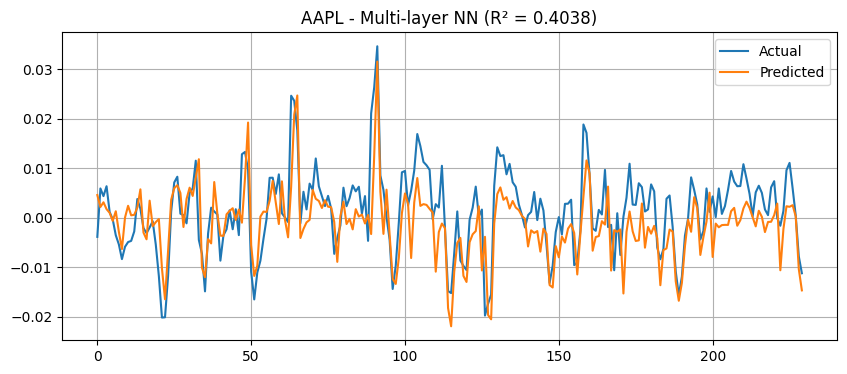


Training MSFT...
Training MSFT model...
Epoch 1/100
Training MSFT model...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 1.7728
Epoch 1: val_loss improved from inf to 0.43808, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.43808, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.8501 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3063
Epoch 2: val_loss improved from 0.43808 to 0.42067, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 2: val_loss improved from 0.43808 to 0.42067, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4037 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8961
Epoch 3: val_loss did not improve from 0.42067
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0144 - val_loss: 0.4738 - learning_rate: 0.0010
Epoch 4/100

Epoch 3: val_loss did not improve from 0.42067
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0144 - val_loss: 0.4738 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8126
Epoch 4: val_loss did not improve from 0.42067
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9358 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 5/100

Epoch 4: val_loss did not improve from 0.42067
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9358 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7348
Epoch 5: val_loss did not improve from 0.42067
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6778 - val_loss: 0.4194 - learning_rate: 0.0010
Epoch 11/100
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3904
Epoch 11: val_loss improved from 0.41940 to 0.41933, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 11: val_loss improved from 0.41940 to 0.41933, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6229 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5707
Epoch 12: val_loss improved from 0.41933 to 0.37238, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 12: val_loss improved from 0.41933 to 0.37238, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6234 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 13/100
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5456
Epoch 13: val_loss improved from 0.37238 to 0.35312, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 13: val_loss improved from 0.37238 to 0.35312, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6446 - val_loss: 0.3531 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6053 
Epoch 14: val_loss improved from 0.35312 to 0.34807, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 14: val_loss improved from 0.35312 to 0.34807, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6047 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 15/100
Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5801
Epoch 15: val_loss improved from 0.34807 to 0.34184, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 15: val_loss improved from 0.34807 to 0.34184, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6290 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 16/100
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4015
Epoch 16: val_loss improved from 0.34184 to 0.34076, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 16: val_loss improved from 0.34184 to 0.34076, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5530 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 17/100
Epoch 17/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6176
Epoch 17: val_loss did not improve from 0.34076
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5870 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 18/100

Epoch 17: val_loss did not improve from 0.34076
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5870 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 18/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4132
Epoch 18: val_loss did not improve from 0.34076
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5415 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 19/100

Epoch 18: val_loss did not improve from 0.34076
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5415 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 19/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7166
Epoch 19: val_loss did not improve from 0.34076
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5027 - val_loss: 0.3340 - learning_rate: 0.0010
Epoch 21/100
Epoch 21/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6878
Epoch 21: val_loss did not improve from 0.33400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5294 - val_loss: 0.3397 - learning_rate: 0.0010
Epoch 22/100

Epoch 21: val_loss did not improve from 0.33400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5294 - val_loss: 0.3397 - learning_rate: 0.0010
Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4495
Epoch 22: val_loss did not improve from 0.33400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5467 - val_loss: 0.3438 - learning_rate: 0.0010
Epoch 23/100

Epoch 22: val_loss did not improve from 0.33400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5467 - val_loss: 0.3438 - learning_rate: 0.0010
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5137
Epoch 23: val_loss did not improve from 0.33400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4841 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 25/100
Epoch 25/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5245
Epoch 25: val_loss did not improve from 0.33116
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4908 - val_loss: 0.3353 - learning_rate: 0.0010
Epoch 26/100

Epoch 25: val_loss did not improve from 0.33116
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4908 - val_loss: 0.3353 - learning_rate: 0.0010
Epoch 26/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4372
Epoch 26: val_loss improved from 0.33116 to 0.32142, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 26: val_loss improved from 0.33116 to 0.32142, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4734 - val_loss: 0.3214 - learning_rate: 0.0010
Epoch 27/100
Epoch 27/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4357
Epoch 27: val_loss improved from 0.32142 to 0.31598, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5

Epoch 27: val_loss improved from 0.32142 to 0.31598, saving model to ../models/saved_model/MSFT_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5152 - val_loss: 0.3160 - learning_rate: 0.0010
Epoch 28/100
Epoch 28/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4219
Epoch 28: val_loss did not improve from 0.31598
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4868 - val_loss: 0.3274 - learning_rate: 0.0010
Epoch 29/100

Epoch 28: val_loss did not improve from 0.31598
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4868 - val_loss: 0.3274 - learning_rate: 0.0010
Epoch 29/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3820
Epoch 29: val_loss did not improve from 0.31598
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4971 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 30/100

Epoch 29: val_loss did not improve from 0.31598
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4971 - val_loss: 0.3261 - learning_rate: 0.0010
Epoch 30/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5193
Epoch 30: val_loss did not improve from 0.31598
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


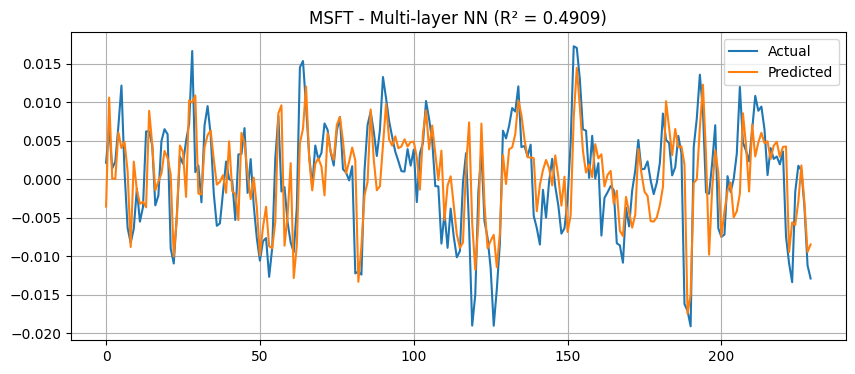


Training JPM...
Training JPM model...
Epoch 1/100
Training JPM model...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 3.2342
Epoch 1: val_loss improved from inf to 0.33896, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.33896, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.4726 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0338Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0338
Epoch 2: val_loss improved from 0.33896 to 0.31208, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 2: val_loss improved from 0.33896 to 0.31208, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5785 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 3/100
Epoch 3/100
 8/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5906 
Epoch 3: val_loss improved from 0.31208 to 0.29560, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 3: val_loss improved from 0.31208 to 0.29560, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3204 - val_loss: 0.2956 - learning_rate: 0.0010
Epoch 4/100
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6518
Epoch 4: val_loss improved from 0.29560 to 0.27436, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 4: val_loss improved from 0.29560 to 0.27436, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0707 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 5/100
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8317
Epoch 5: val_loss did not improve from 0.27436
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9047 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 6/100

Epoch 5: val_loss did not improve from 0.27436
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9047 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7538
Epoch 6: val_loss did not improve from 0.27436
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0616 - val_loss: 0.2806 - learning_rate: 0.0010
Epoch 7/100

Epoch 6: val_loss did not improve from 0.27436
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0616 - val_loss: 0.2806 - learning_rate: 0.0010
Epoch 7/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4880
Epoch 7: val_loss improved from 0.27436 to 0.26253, saving model to ../models/saved_mod

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9694 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 8/100
Epoch 8/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4149
Epoch 8: val_loss improved from 0.26253 to 0.23627, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 8: val_loss improved from 0.26253 to 0.23627, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9062 - val_loss: 0.2363 - learning_rate: 0.0010
Epoch 9/100
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8766
Epoch 9: val_loss improved from 0.23627 to 0.23054, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 9: val_loss improved from 0.23627 to 0.23054, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7767 - val_loss: 0.2305 - learning_rate: 0.0010
Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2695Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2695
Epoch 10: val_loss improved from 0.23054 to 0.21825, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 10: val_loss improved from 0.23054 to 0.21825, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8017 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1680Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.1680
Epoch 11: val_loss improved from 0.21825 to 0.21280, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 11: val_loss improved from 0.21825 to 0.21280, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8193 - val_loss: 0.2128 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7965 
Epoch 12: val_loss did not improve from 0.21280
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7920 - val_loss: 0.2220 - learning_rate: 0.0010
Epoch 13/100

Epoch 12: val_loss did not improve from 0.21280
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7920 - val_loss: 0.2220 - learning_rate: 0.0010
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0969
Epoch 13: val_loss improved from 0.21280 to 0.21158, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 13: val_loss improved from 0.21280 to 0.21158, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6734 - val_loss: 0.2116 - learning_rate: 0.0010
Epoch 14/100
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3342
Epoch 14: val_loss improved from 0.21158 to 0.20243, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 14: val_loss improved from 0.21158 to 0.20243, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6685 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1362Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1362
Epoch 15: val_loss improved from 0.20243 to 0.20138, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 15: val_loss improved from 0.20243 to 0.20138, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6773 - val_loss: 0.2014 - learning_rate: 0.0010
Epoch 16/100
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9234
Epoch 16: val_loss improved from 0.20138 to 0.19464, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 16: val_loss improved from 0.20138 to 0.19464, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6697 - val_loss: 0.1946 - learning_rate: 0.0010
Epoch 17/100
Epoch 17/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6962
Epoch 17: val_loss did not improve from 0.19464
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5565 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 18/100

Epoch 17: val_loss did not improve from 0.19464
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5565 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 18/100
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6160 
Epoch 18: val_loss improved from 0.19464 to 0.17951, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 18: val_loss improved from 0.19464 to 0.17951, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6138 - val_loss: 0.1795 - learning_rate: 0.0010
Epoch 19/100
Epoch 19/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9426
Epoch 19: val_loss improved from 0.17951 to 0.17561, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 19: val_loss improved from 0.17951 to 0.17561, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6009 - val_loss: 0.1756 - learning_rate: 0.0010
Epoch 20/100
Epoch 20/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0298
Epoch 20: val_loss improved from 0.17561 to 0.17275, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 20: val_loss improved from 0.17561 to 0.17275, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6106 - val_loss: 0.1728 - learning_rate: 0.0010
Epoch 21/100
Epoch 21/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8643
Epoch 21: val_loss did not improve from 0.17275
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5902 - val_loss: 0.1730 - learning_rate: 0.0010
Epoch 22/100

Epoch 21: val_loss did not improve from 0.17275
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5902 - val_loss: 0.1730 - learning_rate: 0.0010
Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8362
Epoch 22: val_loss improved from 0.17275 to 0.16870, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5

Epoch 22: val_loss improved from 0.17275 to 0.16870, saving model to ../models/saved_model/JPM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5514 - val_loss: 0.1687 - learning_rate: 0.0010
Epoch 23/100
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2221
Epoch 23: val_loss did not improve from 0.16870
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6428 - val_loss: 0.1726 - learning_rate: 0.0010
Epoch 24/100

Epoch 23: val_loss did not improve from 0.16870
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6428 - val_loss: 0.1726 - learning_rate: 0.0010
Epoch 24/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8443
Epoch 24: val_loss did not improve from 0.16870
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5898 - val_loss: 0.1735 - learning_rate: 0.0010
Epoch 25/100

Epoch 24: val_loss did not improve from 0.16870
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5898 - val_loss: 0.1735 - learning_rate: 0.0010
Epoch 25/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6109
Epoch 25: val_loss did not improve from 0.16870
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


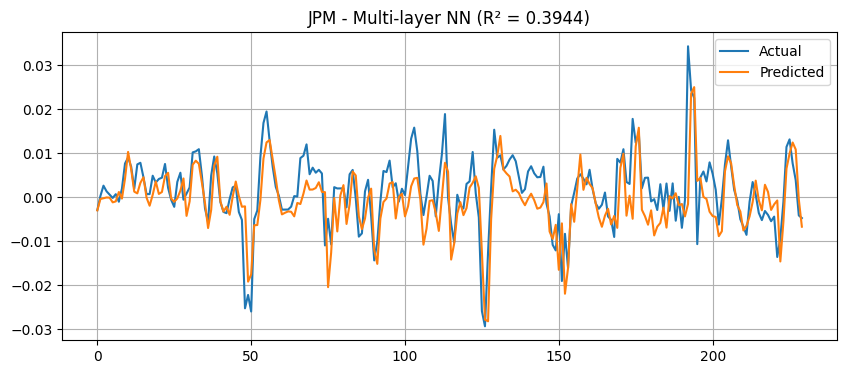


Training BAC...
Training BAC model...
Epoch 1/100
Training BAC model...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 2.9512
Epoch 1: val_loss improved from inf to 0.68939, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.68939, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.3686 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1904
Epoch 2: val_loss improved from 0.68939 to 0.57156, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 2: val_loss improved from 0.68939 to 0.57156, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4032 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4679Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4679
Epoch 3: val_loss improved from 0.57156 to 0.53037, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 3: val_loss improved from 0.57156 to 0.53037, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1644 - val_loss: 0.5304 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4492Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4492
Epoch 4: val_loss improved from 0.53037 to 0.49761, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 4: val_loss improved from 0.53037 to 0.49761, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2448 - val_loss: 0.4976 - learning_rate: 0.0010
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8246Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8246
Epoch 5: val_loss improved from 0.49761 to 0.45030, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 5: val_loss improved from 0.49761 to 0.45030, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0154 - val_loss: 0.4503 - learning_rate: 0.0010
Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2358Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2358
Epoch 6: val_loss improved from 0.45030 to 0.42667, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 6: val_loss improved from 0.45030 to 0.42667, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9863 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 7/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1575Epoch 7/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1575
Epoch 7: val_loss improved from 0.42667 to 0.41214, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 7: val_loss improved from 0.42667 to 0.41214, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9024 - val_loss: 0.4121 - learning_rate: 0.0010
Epoch 8/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7637 Epoch 8/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7637 
Epoch 8: val_loss did not improve from 0.41214
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7680 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8442
Epoch 8: val_loss did not improve from 0.41214
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7680 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8442
Epoch 9: val_loss improved from 0.41214 to 0.39945, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 9: val_loss improved from 0.41214 to 0.39945, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7382 - val_loss: 0.3995 - learning_rate: 0.0010
Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0555Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0555
Epoch 10: val_loss improved from 0.39945 to 0.38772, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 10: val_loss improved from 0.39945 to 0.38772, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8279 - val_loss: 0.3877 - learning_rate: 0.0010
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7674
Epoch 11: val_loss improved from 0.38772 to 0.38192, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7674
Epoch 11: val_loss improved from 0.38772 to 0.38192, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7753 - val_loss: 0.3819 - learning_rate: 0.0010
Epoch 12/100
Epoch 12/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6536 
Epoch 12: val_loss did not improve from 0.38192
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6549 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 13/100

Epoch 12: val_loss did not improve from 0.38192
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6549 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7052
Epoch 13: val_loss did not improve from 0.38192
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6364 - val_loss: 0.3892 - learning_rate: 0.0010
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8266
Epoch 13: val_loss did not improve from 0.38192
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6364 - val_loss: 0.3892 - learning_rate: 0.0010
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8266
Epoch 14: val_loss impro

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6756 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0103Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0103
Epoch 15: val_loss improved from 0.37528 to 0.35956, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 15: val_loss improved from 0.37528 to 0.35956, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6364 - val_loss: 0.3596 - learning_rate: 0.0010
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8128
Epoch 16: val_loss did not improve from 0.35956
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6446 - val_loss: 0.3623 - learning_rate: 0.0010
Epoch 17/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6825Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8128
Epoch 16: val_loss did not improve from 0.35956
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6446 - val_loss: 0.3623 - learning_rate: 0.0010
Epoch 17/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6825
Epoch 17: val_loss improved from 0.35956 to 0.35524, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 17: val_loss improved from 0.35956 to 0.35524, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6036 - val_loss: 0.3552 - learning_rate: 0.0010
Epoch 18/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7063Epoch 18/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7063
Epoch 18: val_loss improved from 0.35524 to 0.34320, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 18: val_loss improved from 0.35524 to 0.34320, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5774 - val_loss: 0.3432 - learning_rate: 0.0010
Epoch 19/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8683
Epoch 19: val_loss improved from 0.34320 to 0.33932, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5
Epoch 19/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8683
Epoch 19: val_loss improved from 0.34320 to 0.33932, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5569 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 20/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5580 Epoch 20/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5580 
Epoch 20: val_loss improved from 0.33932 to 0.32936, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 20: val_loss improved from 0.33932 to 0.32936, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5591 - val_loss: 0.3294 - learning_rate: 0.0010
Epoch 21/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9480
Epoch 21: val_loss improved from 0.32936 to 0.30810, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5
Epoch 21/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9480
Epoch 21: val_loss improved from 0.32936 to 0.30810, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6330 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5820
Epoch 22: val_loss did not improve from 0.30810
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5211 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6358Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5820
Epoch 22: val_loss did not improve from 0.30810
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5211 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6358
Epoch 23: val_loss improved from 0.30810 to 0.30758, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 23: val_loss improved from 0.30810 to 0.30758, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5386 - val_loss: 0.3076 - learning_rate: 0.0010
Epoch 24/100
Epoch 24/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7292
Epoch 24: val_loss did not improve from 0.30758
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7292
Epoch 24: val_loss did not improve from 0.30758
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5438 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5438 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 25/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.5988
Epoch 25: val_loss improved from 0.30758 to 0.30291, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 25: val_loss improved from 0.30758 to 0.30291, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5577 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 26/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3532Epoch 26/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3532
Epoch 26: val_loss improved from 0.30291 to 0.30260, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 26: val_loss improved from 0.30291 to 0.30260, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4869 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 27/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5232Epoch 27/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5232
Epoch 27: val_loss improved from 0.30260 to 0.29749, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 27: val_loss improved from 0.30260 to 0.29749, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4614 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 28/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7146Epoch 28/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7146
Epoch 28: val_loss did not improve from 0.29749
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5055 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 29/100
13/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4416 
Epoch 28: val_loss did not improve from 0.29749
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5055 - val_loss: 0.3081 - learning_rate: 0.0010
Epoch 29/100
13/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4416 
Epoch 29: val_loss did not improve from 0.29749
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4413 - val_loss: 0.3158 - learning_rate: 0.0010
Epoch 30/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6241
Epoch 30: val_loss did not improve from 0.29749
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5039 - val_loss: 0.3145 - learni

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4502 - val_loss: 0.2954 - learning_rate: 2.0000e-04
Epoch 48/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5657Epoch 48/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5657
Epoch 48: val_loss improved from 0.29538 to 0.29352, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 48: val_loss improved from 0.29538 to 0.29352, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4121 - val_loss: 0.2935 - learning_rate: 2.0000e-04
Epoch 49/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6677
Epoch 49: val_loss improved from 0.29352 to 0.29312, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5
Epoch 49/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6677
Epoch 49: val_loss improved from 0.29352 to 0.29312, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4254 - val_loss: 0.2931 - learning_rate: 2.0000e-04
Epoch 50/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5642Epoch 50/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5642
Epoch 50: val_loss improved from 0.29312 to 0.29253, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5

Epoch 50: val_loss improved from 0.29312 to 0.29253, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4256 - val_loss: 0.2925 - learning_rate: 2.0000e-04
Epoch 51/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5690
Epoch 51: val_loss improved from 0.29253 to 0.29245, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5
Epoch 51/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5690
Epoch 51: val_loss improved from 0.29253 to 0.29245, saving model to ../models/saved_model/BAC_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4223 - val_loss: 0.2925 - learning_rate: 2.0000e-04
Epoch 52/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4783Epoch 52/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4783
Epoch 52: val_loss did not improve from 0.29245
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4428 - val_loss: 0.2948 - learning_rate: 2.0000e-04
Epoch 53/100

Epoch 52: val_loss did not improve from 0.29245
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4428 - val_loss: 0.2948 - learning_rate: 2.0000e-04
Epoch 53/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5519
Epoch 53: val_loss did not improve from 0.29245
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4307 - val_loss: 0.2971 - learning_rate: 2.0000e-04
Epoch 54/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4091
Epoch 54: val_loss did not improve from 0.29245

Epoch 53: val_loss did not improve from 0.29245
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4307 - val_loss: 0.29

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


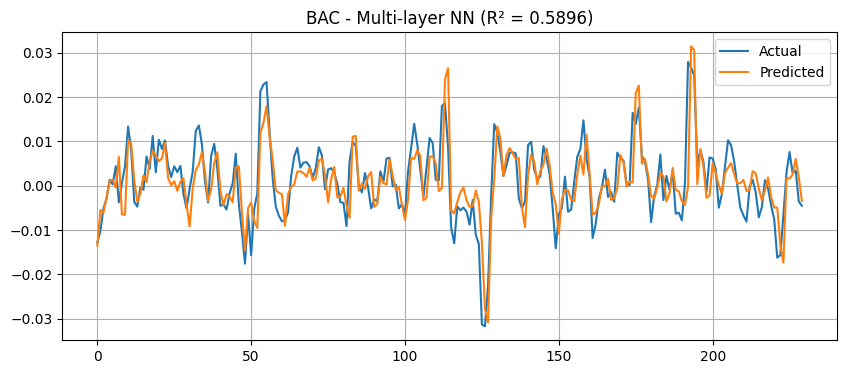


Training XOM...
Training XOM model...
Epoch 1/100
Training XOM model...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 2.9906
Epoch 1: val_loss improved from inf to 0.45797, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.45797, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.5648 - val_loss: 0.4580 - learning_rate: 0.0010
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3133
Epoch 2: val_loss did not improve from 0.45797
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3988 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0566Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3133
Epoch 2: val_loss did not improve from 0.45797
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3988 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0566
Epoch 3: val_loss improved from 0.45797 to 0.44260, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5

Epoch 3: val_loss improved from 0.45797 to 0.44260, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0742 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5970Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5970
Epoch 4: val_loss improved from 0.44260 to 0.41881, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5

Epoch 4: val_loss improved from 0.44260 to 0.41881, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9772 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6435
Epoch 5: val_loss did not improve from 0.41881
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6435
Epoch 5: val_loss did not improve from 0.41881
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8953 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4624
Epoch 6: val_loss improved from 0.41881 to 0.40741, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8953 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4624
Epoch 6: val_loss improved from 0.41881 to 0.40741, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8001 - val_loss: 0.4074 - learning_rate: 0.0010
Epoch 7/100
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8798 
Epoch 7: val_loss improved from 0.40741 to 0.39833, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
Epoch 7/100
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8798 
Epoch 7: val_loss improved from 0.40741 to 0.39833, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8766 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 8/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3687
Epoch 8: val_loss improved from 0.39833 to 0.37611, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
Epoch 8/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3687
Epoch 8: val_loss improved from 0.39833 to 0.37611, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7543 - val_loss: 0.3761 - learning_rate: 0.0010
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5829Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5829
Epoch 9: val_loss improved from 0.37611 to 0.33394, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5

Epoch 9: val_loss improved from 0.37611 to 0.33394, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6891 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 10/100
Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4710
Epoch 10: val_loss improved from 0.33394 to 0.32514, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4710
Epoch 10: val_loss improved from 0.33394 to 0.32514, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7124 - val_loss: 0.3251 - learning_rate: 0.0010
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5185
Epoch 11: val_loss improved from 0.32514 to 0.30398, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5185
Epoch 11: val_loss improved from 0.32514 to 0.30398, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6757 - val_loss: 0.3040 - learning_rate: 0.0010
Epoch 12/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6306 
Epoch 12: val_loss improved from 0.30398 to 0.28747, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
Epoch 12/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6306 
Epoch 12: val_loss improved from 0.30398 to 0.28747, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6397 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4898
Epoch 13: val_loss did not improve from 0.28747
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6959 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4667Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4898
Epoch 13: val_loss did not improve from 0.28747
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6959 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4667
Epoch 14: val_loss improved from 0.28747 to 0.28468, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5

Epoch 14: val_loss improved from 0.28747 to 0.28468, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5987 - val_loss: 0.2847 - learning_rate: 0.0010
Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3810
Epoch 15: val_loss improved from 0.28468 to 0.26938, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5
Epoch 15/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3810
Epoch 15: val_loss improved from 0.28468 to 0.26938, saving model to ../models/saved_model/XOM_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5868 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3124
Epoch 16: val_loss did not improve from 0.26938
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5639 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 17/100
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3124
Epoch 16: val_loss did not improve from 0.26938
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5639 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 17/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4672
Epoch 17: val_loss did not improve from 0.26938
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5987 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 18/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4022
Epoch 18: val_loss did not improve from 0.26938
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6072 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 19/100
 1/23 ━━━━━━━━━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


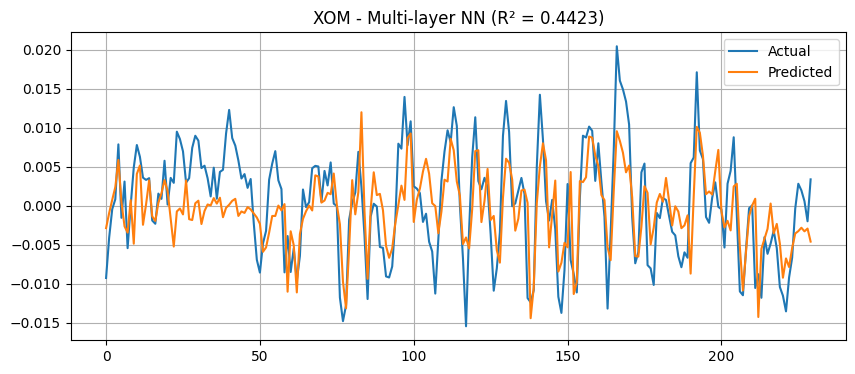


Training CVX...
Training CVX model...
Epoch 1/100
Training CVX model...
Epoch 1/100


d:\Dev\stock-forecasting-neural-networks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 3.0676
Epoch 1: val_loss improved from inf to 0.50284, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.50284, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.0516 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 2/100
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6491
Epoch 2: val_loss improved from 0.50284 to 0.48212, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 2: val_loss improved from 0.50284 to 0.48212, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5504 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1141Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1141
Epoch 3: val_loss improved from 0.48212 to 0.47252, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 3: val_loss improved from 0.48212 to 0.47252, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1534 - val_loss: 0.4725 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2672Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2672
Epoch 4: val_loss improved from 0.47252 to 0.44523, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 4: val_loss improved from 0.47252 to 0.44523, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1103 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5921
Epoch 5: val_loss improved from 0.44523 to 0.43097, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 5/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5921
Epoch 5: val_loss improved from 0.44523 to 0.43097, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9519 - val_loss: 0.4310 - learning_rate: 0.0010
Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2629Epoch 6/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2629
Epoch 6: val_loss improved from 0.43097 to 0.39636, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 6: val_loss improved from 0.43097 to 0.39636, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9750 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 7/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8052
Epoch 7: val_loss improved from 0.39636 to 0.35019, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 7/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8052
Epoch 7: val_loss improved from 0.39636 to 0.35019, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8992 - val_loss: 0.3502 - learning_rate: 0.0010
Epoch 8/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8670Epoch 8/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8670
Epoch 8: val_loss did not improve from 0.35019
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8169 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6941
Epoch 9: val_loss improved from 0.35019 to 0.34827, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 8: val_loss did not improve from 0.35019
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8169 - val_loss: 0.3619 - learning_rate: 0.0010
Epoch 9/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6941
Epoch 9: val_loss improved from 0.35019 to 0.34827, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8338 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6237Epoch 10/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6237
Epoch 10: val_loss improved from 0.34827 to 0.31710, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5

Epoch 10: val_loss improved from 0.34827 to 0.31710, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7736 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5498
Epoch 11: val_loss improved from 0.31710 to 0.31452, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 11/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5498
Epoch 11: val_loss improved from 0.31710 to 0.31452, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6983 - val_loss: 0.3145 - learning_rate: 0.0010
Epoch 12/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6019
Epoch 12: val_loss did not improve from 0.31452
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7682 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5849
Epoch 13: val_loss did not improve from 0.31452
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7349 - val_loss: 0.3282 - learning_rate: 0.0010
Epoch 14/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4590
Epoch 14: val_loss improved from 0.31452 to 0.30762, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 12/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6019
Epoch 12: val_loss did not improve from 0.31452
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7682 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 13/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5849
Epoch 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6504 - val_loss: 0.3076 - learning_rate: 0.0010
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6603 
Epoch 15: val_loss improved from 0.30762 to 0.29691, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6603 
Epoch 15: val_loss improved from 0.30762 to 0.29691, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6611 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4761
Epoch 16: val_loss did not improve from 0.29691
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6357 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6356 
Epoch 17: val_loss did not improve from 0.29691
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6357 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 18/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5453Epoch 16/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4761
Epoch 16: val_loss did not improve from 0.29691
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6357 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6356 
Epoch 17: val_loss did not improve from 0.29691
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6357 - val_loss: 0.3019 - learni

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5696 - val_loss: 0.2950 - learning_rate: 0.0010
Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7360
Epoch 22: val_loss improved from 0.29502 to 0.28516, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 22/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7360
Epoch 22: val_loss improved from 0.29502 to 0.28516, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5677 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5683
Epoch 23: val_loss improved from 0.28516 to 0.27890, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 23/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5683
Epoch 23: val_loss improved from 0.28516 to 0.27890, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5101 - val_loss: 0.2789 - learning_rate: 0.0010
Epoch 24/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6403
Epoch 24: val_loss did not improve from 0.27890
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5917 - val_loss: 0.2825 - learning_rate: 0.0010
Epoch 25/100
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5508 
Epoch 25: val_loss did not improve from 0.27890
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5435 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 26/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5443 
Epoch 26: val_loss did not improve from 0.27890
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5481 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 27/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5270 
Epoch 27: val_loss did not improve from 0.27890
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5276 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 28/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5510 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 29/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5185
Epoch 29: val_loss improved from 0.27883 to 0.27826, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 29/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5185
Epoch 29: val_loss improved from 0.27883 to 0.27826, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5288 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 30/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5825
Epoch 30: val_loss did not improve from 0.27826
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5078 - val_loss: 0.2794 - learning_rate: 0.0010
Epoch 31/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5532
Epoch 31: val_loss improved from 0.27826 to 0.27526, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5
Epoch 30/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5825
Epoch 30: val_loss did not improve from 0.27826
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5078 - val_loss: 0.2794 - learning_rate: 0.0010
Epoch 31/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5532
Epoch 31: val_loss improved from 0.27826 to 0.27526, saving model to ../models/saved_model/CVX_weights/best_checkpoint.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5132 - val_loss: 0.2753 - learning_rate: 0.0010
Epoch 32/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5193Epoch 32/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5193
Epoch 32: val_loss did not improve from 0.27526
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4720 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 33/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3662
Epoch 33: val_loss did not improve from 0.27526
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4612 - val_loss: 0.2821 - learning_rate: 0.0010
Epoch 34/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5783
Epoch 34: val_loss did not improve from 0.27526
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5011 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 35/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5354
Epoch 32: val_loss did not improve from 0.27526
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4720 - val_loss: 0.2756 - learn

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


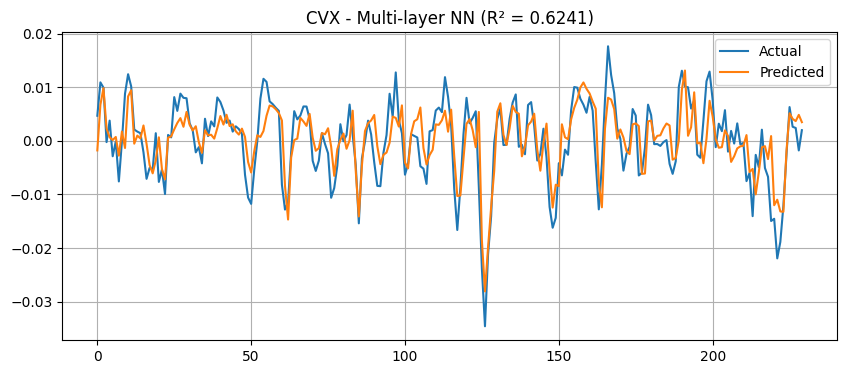


SUMMARY OF MULTI-LAYER NN MODEL
AAPL: MSE = 0.000041, R² = 0.4038
MSFT: MSE = 0.000025, R² = 0.4909
JPM: MSE = 0.000040, R² = 0.3944
BAC: MSE = 0.000030, R² = 0.5896
XOM: MSE = 0.000027, R² = 0.4423
CVX: MSE = 0.000021, R² = 0.6241


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import mutual_info_regression, SelectKBest

# Reproducibility
import random
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

tickers = ['AAPL', 'MSFT', 'JPM', 'BAC', 'XOM', 'CVX']
results = {}

for ticker in tickers:
    print(f"\nTraining {ticker}...")
    df = pd.read_csv(f'../data/processed/{ticker}_processed.csv', index_col='Date', parse_dates=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # === Enhanced Feature Engineering ===
    # Price-based features
    df['Return'] = df['Close'].pct_change()
    df['Return_Abs'] = np.abs(df['Return'])
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Return lags - capture autocorrelation patterns
    for i in range(1, 10):
        df[f'Lag_{i}'] = df['Return'].shift(i)
        if i <= 5:  # Create interaction terms for closer lags
            df[f'Lag_{i}_squared'] = df[f'Lag_{i}']**2
            
    # Momentum indicators at different timeframes
    for window in [5, 10, 20, 30]:
        df[f'Momentum_{window}'] = df['Close'] - df['Close'].shift(window)
        df[f'Momentum_Ratio_{window}'] = df['Close'] / df['Close'].shift(window)
    
    # Moving averages
    for window in [5, 10, 20, 50, 100]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        # Distance to moving average (normalized)
        df[f'Close_MA_{window}_Ratio'] = df['Close'] / df[f'MA_{window}']
    
    # Volatility features at different timeframes
    for window in [5, 10, 20, 30]:
        df[f'Volatility_{window}'] = df['Return'].rolling(window=window).std()
        # Add normalized volatility
        if window in [5, 10]:
            df[f'Volatility_Ratio_{window}'] = df[f'Volatility_{window}'] / df[f'Volatility_{window}'].rolling(window=5).mean()
    
    # RSI at multiple timeframes
    for window in [6, 14, 21]:
        delta = df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window).mean()
        loss = -delta.clip(upper=0).rolling(window).mean()
        rs = gain / (loss.replace(0, np.finfo(float).eps))
        df[f'RSI_{window}'] = 100 - (100 / (1 + rs))
    
    # MACD variants
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    df['MACD_hist_diff'] = df['MACD_hist'].diff() # Change in histogram
    
    # Bollinger Bands
    for window in [20]:
        middle_band = df['Close'].rolling(window=window).mean()
        std_dev = df['Close'].rolling(window=window).std()
        df[f'BB_upper_{window}'] = middle_band + (std_dev * 2)
        df[f'BB_lower_{window}'] = middle_band - (std_dev * 2)
        df[f'BB_width_{window}'] = (df[f'BB_upper_{window}'] - df[f'BB_lower_{window}']) / middle_band
        df[f'BB_position_{window}'] = (df['Close'] - df[f'BB_lower_{window}']) / (df[f'BB_upper_{window}'] - df[f'BB_lower_{window}'])
    
    # Rate of Change
    for window in [5, 10, 21]:
        df[f'ROC_{window}'] = df['Close'].pct_change(window) * 100
    
    # Volume features (if available)
    if 'Volume' in df.columns:
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
        df['Log_Volume'] = np.log(df['Volume'] + 1)
        df['Volume_Change'] = df['Volume'].pct_change()
        
        # Volume moving averages
        for window in [5, 10, 20]:
            df[f'Volume_SMA_{window}'] = df['Volume'].rolling(window).mean()
            df[f'Volume_Ratio_{window}'] = df['Volume'] / df[f'Volume_SMA_{window}']
        
        # Volume and price relationships
        df['Volume_Return_Ratio'] = df['Volume'] / (df['Return_Abs'] + 0.001)
        df['Volume_Close_Ratio'] = df['Volume'] / df['Close']

    # === Target: 3-day smoothed forward log return ===
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = df['LogReturn'].shift(-1).rolling(3).mean()

    # Drop rows with NaN values
    df = df.dropna()
    
    # Handle outliers - clip extreme values using percentiles
    for col in df.columns:
        if col != 'Close' and col != 'Target':  # Don't clip the Close price or target
            lower_bound = df[col].quantile(0.005)
            upper_bound = df[col].quantile(0.995)
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Feature selection using mutual information
    if df.shape[1] > 30:  # If we have many features
        X_temp = df.drop(columns=['Close', 'Target', 'LogReturn', 'Return'])
        y_temp = df['Target']
        
        # Calculate mutual information scores
        mi_scores = mutual_info_regression(X_temp, y_temp)
        mi_df = pd.DataFrame({'Feature': X_temp.columns, 'MI_Score': mi_scores})
        mi_df = mi_df.sort_values('MI_Score', ascending=False)
        
        # Select top 25 features + any essential ones we want to keep
        top_features = mi_df.head(25)['Feature'].tolist()
        essential_features = [col for col in X_temp.columns if 'RSI' in col or 'MACD' in col or 'Momentum' in col or 'Volatility' in col]
        selected_features = list(set(top_features + essential_features))
        
        # Create feature dataframe with only selected features
        X = df[selected_features]
    else:
        # Drop unused columns
        X = df.drop(columns=['Return', 'Close', 'Target', 'LogReturn', 'Log_Return'])
    
    y = df['Target']

    # === Normalize target ===
    y_mean, y_std = y.mean(), y.std()
    y_train, y_test = train_test_split(y, shuffle=False, test_size=0.2)
    y_train_norm = (y_train - y_mean) / y_std
    y_test_norm = (y_test - y_mean) / y_std

    # === Train-test split ===
    X_train, X_test = train_test_split(X, shuffle=False, test_size=0.2)

    # Create a more robust scaling approach
    scaler = RobustScaler()  # Less influenced by outliers
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # === Effective Neural Network Architecture ===
    # Build a well-balanced architecture with appropriate regularization
    
    # Build Sequential model
    model = Sequential([
        # First layer - capture complex patterns
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), 
              kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second layer - intermediate representation
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Third layer - final feature extraction
        Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.1),
        
        # Output layer
        Dense(1)
    ])
    
    # Compile with Adam optimizer
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    # === Training Strategy ===
    
    # Create a weight folder for this ticker
    model_folder = f'../models/saved_model/{ticker}_weights'
    os.makedirs(model_folder, exist_ok=True)
    
    # Model checkpoint to save the best model
    checkpoint = ModelCheckpoint(
        filepath=f'{model_folder}/best_checkpoint.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    # Early stopping with appropriate patience
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        mode='min',
        verbose=1
    )
    
    # Learning rate reduction on plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
    
    # Train model with validation split
    print(f"Training {ticker} model...")
    history = model.fit(
        X_train_scaled, y_train_norm,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )

    # Save model
    os.makedirs('../models/saved_model', exist_ok=True)
    model.save(f'../models/saved_model/{ticker}_multi_layer.h5')

    # === Predict and Evaluate ===
    y_pred_norm = model.predict(X_test_scaled).flatten()
    y_pred = y_pred_norm * y_std + y_mean
    y_test_actual = y_test.values

    mse = mean_squared_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)
    results[ticker] = (mse, r2)

    # Plot predictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{ticker} - Multi-layer NN (R² = {r2:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()

# === Summary Output ===
print("\nSUMMARY OF MULTI-LAYER NN MODEL")
for ticker, (mse, r2) in results.items():
    print(f"{ticker}: MSE = {mse:.6f}, R² = {r2:.4f}")